In [8]:
import sys, os, time
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import ConcatDataset, Dataset, DataLoader
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint
import gym
import h5py as hf

%load_ext autoreload
%autoreload 2

import foundation as fd
from foundation import util
from foundation import nets
from foundation import train

from nb_backend import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100

seq_len = 10
step_len = 1

num_workers = 4

niters = 100
lr = 1e-2
device = 'cpu' #torch.device('cuda:0')
dataroots = ['/mnt/c/Users/anwan/Documents/ml_data/cartpole/cp-noimg-mass1/',]

In [52]:
datafiles = sum([[os.path.join(dd, df) for df in os.listdir(dd)] for dd in dataroots],[])
class H5_Seq_Dataset(Dataset):
    def __init__(self, filename, seq_len, step_len=1):
        super().__init__()
        
        with hf.File(filename, 'r') as f:
            B, K, _ = f['states'].shape
        
        self.filename = filename
        self.batch = B
        self.row = K - (seq_len+1)*step_len
        self.seq_len = seq_len
        self.step_len = step_len
        
    def __len__(self):
        return self.batch*self.row
    
    def __getitem__(self, idx):
        i = idx // self.batch
        k = idx % self.batch
        
        sample = {}
        
        with hf.File(self.filename, 'r') as f:
            states = f['states'][i, k:k+(self.seq_len+1)*self.step_len:self.step_len]
            controls = f['controls'][i, k:k+(self.seq_len)*self.step_len:self.step_len]
            context = f['masses'].value
            
        states = torch.from_numpy(states)
        
        x, theta = states[...,:1], states[...,1:2]
        cos, sin = np.cos(theta), np.sin(theta)
        
        states = np.concatenate([x, cos, sin, states[...,2:]], -1)
        
        sample['states'] = states
        sample['controls'] = controls
        sample['context'] = context
        return sample
        
len(datafiles)

24

In [53]:
datasets = [H5_Seq_Dataset(fname, seq_len, step_len) for fname in datafiles]
datasets = ConcatDataset(datasets[:18]), ConcatDataset(datasets[18:21]), ConcatDataset(datasets[21:])
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=16, num_workers=num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))

traindata len=1814400, trainloader len=113400
valdata len=302400, valloader len=18900
testdata len=302400, testloader len=18900


In [54]:
for sample in trainloader:
    break

In [55]:
states, controls, context = sample['states'].to(device), sample['controls'].to(device), sample['context'].to(device)
states.shape, controls.shape, context.shape

(torch.Size([16, 11, 5]), torch.Size([16, 10, 1]), torch.Size([16, 1]))

In [8]:
samp_ts

tensor([0.0000, 0.0378, 0.0755, 0.1133, 0.1511, 0.1889, 0.2266, 0.2644, 0.3022,
        0.3400, 0.3777, 0.4155, 0.4533, 0.4911, 0.5288, 0.5666, 0.6044, 0.6422,
        0.6799, 0.7177, 0.7555, 0.7933, 0.8310, 0.8688, 0.9066, 0.9444, 0.9821,
        1.0199, 1.0577, 1.0955, 1.1332, 1.1710, 1.2088, 1.2466, 1.2843, 1.3221,
        1.3599, 1.3977, 1.4354, 1.4732, 1.5110, 1.5488, 1.5865, 1.6243, 1.6621,
        1.6999, 1.7376, 1.7754, 1.8132, 1.8510, 1.8887, 1.9265, 1.9643, 2.0021,
        2.0398, 2.0776, 2.1154, 2.1532, 2.1909, 2.2287, 2.2665, 2.3043, 2.3420,
        2.3798, 2.4176, 2.4554, 2.4931, 2.5309, 2.5687, 2.6065, 2.6442, 2.6820,
        2.7198, 2.7576, 2.7953, 2.8331, 2.8709, 2.9086, 2.9464, 2.9842, 3.0220,
        3.0597, 3.0975, 3.1353, 3.1731, 3.2108, 3.2486, 3.2864, 3.3242, 3.3619,
        3.3997, 3.4375, 3.4753, 3.5130, 3.5508, 3.5886, 3.6264, 3.6641, 3.7019,
        3.7397], device='cuda:0')

In [9]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
print(func)
print(rec)
print(dec)
cnt = list(map(util.count_parameters, [func, rec, dec]))
print(cnt, sum(cnt))

LatentODEfunc(
  (elu): ELU(alpha=1.0, inplace)
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=4, bias=True)
)
RecognitionRNN(
  (i2h): Linear(in_features=27, out_features=25, bias=True)
  (h2o): Linear(in_features=25, out_features=8, bias=True)
)
Decoder(
  (relu): ReLU(inplace)
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)
[604, 908, 142] 1654


In [11]:
itr = 0

In [56]:
optimizer.zero_grad()
# backward in time to infer q(z_0)
h = rec.initHidden().to(device)
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
pred_x = dec(pred_z)

# compute loss
noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
noise_logvar = 2. * torch.log(noise_std_).to(device)
logpx = log_normal_pdf(
    samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                        pz0_mean, pz0_logvar).sum(-1)
#loss = torch.mean(-logpx + analytic_kl, dim=0)

loss = torch.mean(-logpx, dim=0)
loss.backward()
optimizer.step()
loss_meter.update(loss.item())

print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

itr += 1

NameError: name 'optimizer' is not defined

In [97]:
optimizer.zero_grad()
# backward in time to infer q(z_0)
h = rec.initHidden().to(device)
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
qz0 = distrib.Normal(qz0_mean, qz0_logvar.exp())
#epsilon = torch.randn(qz0_mean.size()).to(device)
#z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
z0 = qz0.rsample()

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
pred_x = dec(pred_z)

# compute loss
noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
noise_logvar = 2. * torch.log(noise_std_).to(device)
#logpx = log_normal_pdf(samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
px = distrib.Normal(pred_x, noise_std*torch.ones(*pred_x.size()).to(device))
logpx = px.log_prob(samp_trajs).sum(-1).sum(-1)
pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
analytic_kl = distrib.kl_divergence(qz0, None).sum(-1)
loss = torch.mean(-logpx + analytic_kl, dim=0)
loss.backward()
optimizer.step()
loss_meter.update(loss.item())

print('Iter: {}, running avg elbo: {:.4f} ({:.4f}, {:.4f})'.format(itr, -loss_meter.avg, logpx.mean().item(), analytic_kl.mean().item()))

itr += 1

Iter: 64, running avg elbo: -6543.8469 (-945.5022, 35.5000)


In [98]:
analytic_kl.shape

torch.Size([1000])

<IPython.core.display.Javascript object>


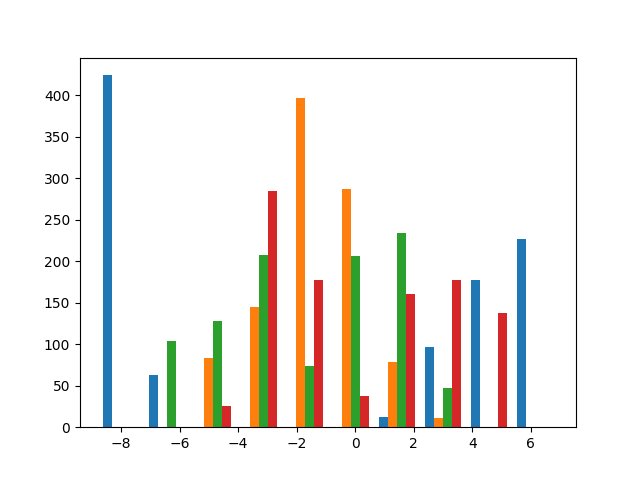

([array([424.,  63.,   0.,   0.,   0.,   0.,  12.,  97., 177., 227.]),
  array([  0.,   0.,  83., 145., 396., 287.,  78.,  11.,   0.,   0.]),
  array([  0., 104., 128., 207.,  74., 206., 234.,  47.,   0.,   0.]),
  array([  0.,   0.,  25., 285., 177.,  38., 160., 177., 138.,   0.])],
 array([-8.791216  , -7.2189283 , -5.646641  , -4.0743527 , -2.5020652 ,
        -0.9297776 ,  0.64251006,  2.2147977 ,  3.7870853 ,  5.359373  ,
         6.9316607 ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

In [99]:
plt.figure()
plt.hist(z0.detach().cpu().numpy())

In [100]:
sample = torch.randn(10, 4).to(device)

In [101]:
z = odeint(func, sample, samp_ts).permute(1, 0, 2)
x = dec(z)
z.shape, x.shape

(torch.Size([10, 100, 4]), torch.Size([10, 100, 2]))

<IPython.core.display.Javascript object>


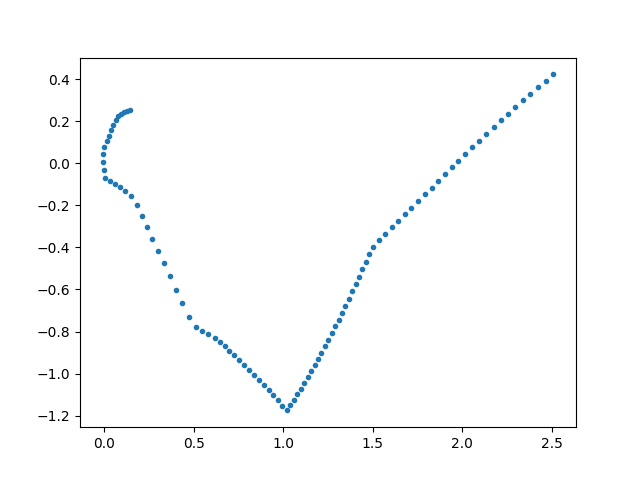

In [103]:
plt.figure()
idx = 4
plt.plot(*x[idx].detach().cpu().numpy().T, ls='', marker='.')